## IE360 PROJECT



**Table of Contents**

1. Introduction
2. Data Upload
3. Data Preparation for Linear Regression
4. Linear Regression Model
5. Hybrid Model (Linear Regression and ARIMA model on Residuals)
6. ARIMA Model
7. Seasonal ARIMA Model
8. Model Comparisons


**1. Introduction**

This project tackles the task of predicting hourly solar power production for Edikli GES, a solar power plant located in Niğde, Turkey. The predictions will be made for the next day. Day ahead predictions will be evaluated in the test period from February 1st to May 15th.

Four different time series regression models will be presented and these models will be compared in terms of weighted mean absolute percentage error (WMAPE)

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from datetime import datetime, timedelta
from prettytable import PrettyTable

**2. Data Upload**

While the weather information collected across various grid points provides a comprehensive dataset, its individual analysis might not be the most practical approach. The expansive areas encompassed by each grid point, relative to the specific location of the solar power plant, can limit the actionable insights from this data. Additionally, variables like cloud cover, temperature, and downward shortwave radiation flux (DSWR) tend to exhibit high levels of correlation at this scale. To address these limitations and explore potentially more meaningful relationships, the decision was made to **calculate average values** for each weather variable across all grid points. This approach not only mitigates the issue of multicollinearity observed in the visualizations of the coordinate-based data but also simplifies the analysis by focusing on central tendencies within the surrounding area.

In [3]:
weather_info_path = './weather_info.csv'
weather_info_df = pd.read_csv(weather_info_path)

# Combining 'date' and 'hour' into a single datetime column at the start
weather_info_df['datetime'] = pd.to_datetime(weather_info_df['date'] +
                                             ' ' + weather_info_df['hour'].astype(str) + ':00')

# Moving 'datetime' to the first column
column_order = ['datetime'] + [col for col in weather_info_df.columns if col != 'datetime']
weather_info_df = weather_info_df[column_order]

weather_info_df.drop(['date', 'hour'], axis=1, inplace=True)

column_names_list = weather_info_df.columns.tolist()

weather_info_df = weather_info_df.groupby('datetime')[column_names_list[3:]].mean().reset_index()

# Display the updated DataFrame
weather_info_df.tail(24)

,datetime,DSWRF_surface,TCDC_low.cloud.layer,TCDC_middle.cloud.layer,TCDC_high.cloud.layer,TCDC_entire.atmosphere,USWRF_top_of_atmosphere,CSNOW_surface,DLWRF_surface,USWRF_surface,TMP_surface
20196,2024-04-21 16:00:00,713.71680,4.192,4.296,0.000,7.436,171.85536,0.0,286.743,125.45856,298.88800
20197,2024-04-21 17:00:00,618.40960,5.900,5.624,0.000,10.416,165.13600,0.0,286.919,114.39552,295.21700
20198,2024-04-21 18:00:00,518.55120,5.616,5.216,0.000,9.824,150.95040,0.0,285.571,100.49088,291.17600
20199,2024-04-21 19:00:00,416.84320,4.968,6.592,0.324,11.048,130.52672,0.0,283.707,82.80960,286.88020
20200,2024-04-21 20:00:00,334.15936,4.124,6.528,1.060,11.036,105.25760,0.0,281.743,66.40448,284.84024
20201,2024-04-21 21:00:00,278.46464,3.788,6.016,1.720,10.784,87.71328,0.0,280.175,55.33568,284.11700
20202,2024-04-21 22:00:00,0.00000,1.808,0.848,5.344,8.196,0.00000,0.0,270.431,0.00000,283.41300
20203,2024-04-21 23:00:00,0.00000,1.936,0.428,8.928,11.908,0.00000,0.0,269.372,0.00000,282.77200
20204,2024-04-22 00:00:00,0.00000,3.392,0.336,15.036,19.172,0.00000,0.0,270.504,0.00000,282.36272
20205,2024-04-22 01:00:00,0.00000,3.884,0.240,35.812,38.928,0.00000,0.0,271.112,0.00000,282.06400


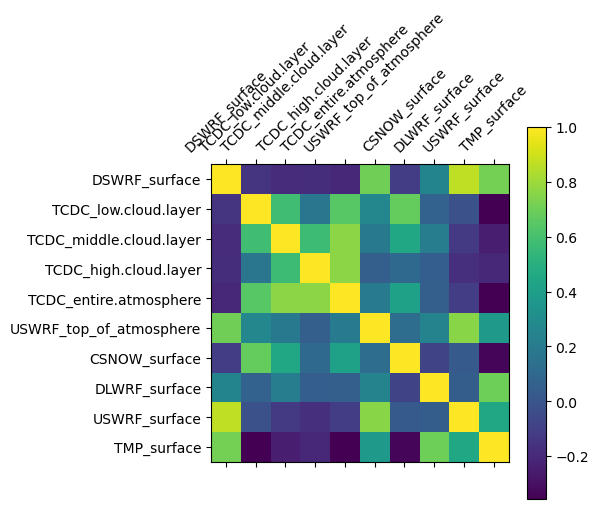

In [4]:
correlation_matrix = weather_info_df.corr()
plt.matshow(correlation_matrix)
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.colorbar()
plt.show()



For the production data, date and hour columns are merged and line graph and autocorrelation function is plotted for our test period for better visualisations (February - May 2024)

In [5]:
production_path = './production.csv'
production_df = pd.read_csv(production_path)

# Combine 'date' and 'hour' into a single datetime column
production_df['datetime'] = pd.to_datetime(production_df['date'] + ' ' + production_df['hour'].astype(str) + ':00')

# Move 'datetime' to the first column
column_order = ['datetime'] + [col for col in production_df.columns if col != 'datetime']
production_df = production_df[column_order]

# Drop the old date and hour columns
production_df.drop(['date', 'hour'], axis=1, inplace=True)

# Display the modified production dataframe
production_df.tail(24)

,datetime,production
20112,2024-04-16 00:00:00,0.00
20113,2024-04-16 01:00:00,0.00
20114,2024-04-16 02:00:00,0.00
20115,2024-04-16 03:00:00,0.00
20116,2024-04-16 04:00:00,0.00
20117,2024-04-16 05:00:00,0.23
20118,2024-04-16 06:00:00,2.32
20119,2024-04-16 07:00:00,5.96
20120,2024-04-16 08:00:00,8.83
20121,2024-04-16 09:00:00,9.85


In [6]:
production_df = production_df[production_df['datetime'] >= '2022-02-01']
weather_info_df = weather_info_df[weather_info_df['datetime'] >= '2022-02-01']

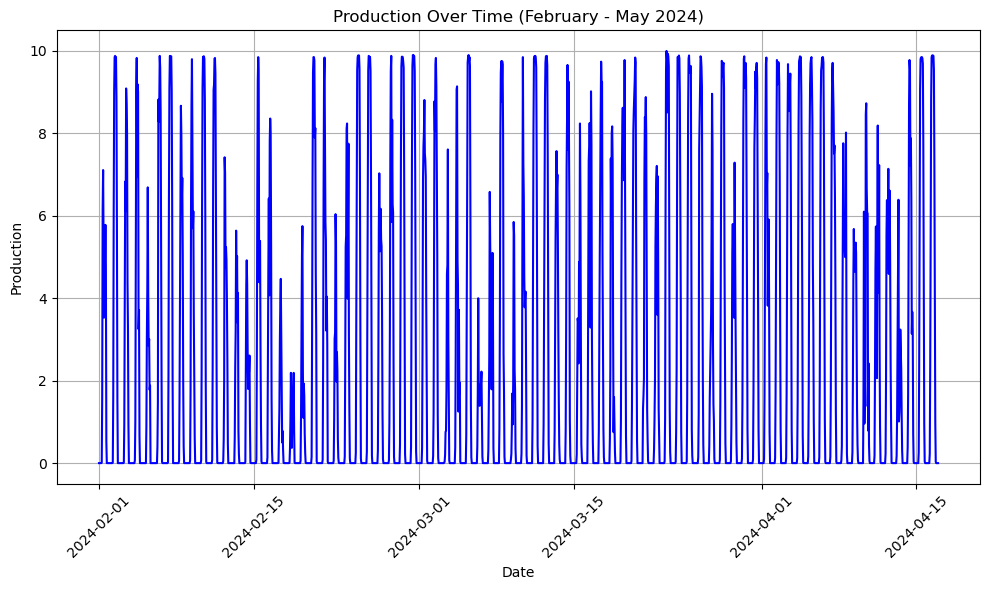

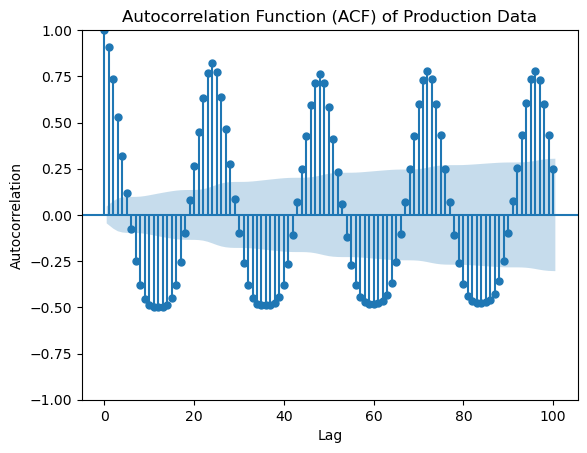

In [7]:
filtered_production_df = production_df[(production_df['datetime'] >= '2024-02-01') & (production_df['datetime'] < '2024-06-01')]

# Plot production over time
plt.figure(figsize=(10, 6))
plt.plot(filtered_production_df['datetime'], filtered_production_df['production'], color='blue')
plt.title('Production Over Time (February - May 2024)')
plt.xlabel('Date')
plt.ylabel('Production')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# ACF Plot
sm.graphics.tsa.plot_acf(filtered_production_df['production'], lags=100)
plt.title('Autocorrelation Function (ACF) of Production Data')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

Daily seasonality for the production data is easily observed. Production volume at hour h in the last day and production at hour h in the previous days are correlated. Therefore, the effects of each variable might differ considerably for different production hours. 

Therefore, one of our approaches will be to divide the production data into 24 hours and make predictions for each hourly data for the next day. Thus, at the end, there will be 24 different models at best, given that there are distinct models for each hour. (Hourly auto.arima model)

In [8]:
merged_df = pd.merge(production_df, weather_info_df, on='datetime', how='inner')
merged_df = merged_df.dropna()
merged_df.tail(12)

,datetime,production,DSWRF_surface,TCDC_low.cloud.layer,TCDC_middle.cloud.layer,TCDC_high.cloud.layer,TCDC_entire.atmosphere,USWRF_top_of_atmosphere,CSNOW_surface,DLWRF_surface,USWRF_surface,TMP_surface
19380,2024-04-16 12:00:00,9.89,802.95440,0.0,0.0,3.228,3.432,175.41952,0.0,270.6370,136.87616,303.73116
19381,2024-04-16 13:00:00,9.88,844.07360,0.0,0.0,4.760,4.932,178.26688,0.0,273.4590,140.47232,304.81700
19382,2024-04-16 14:00:00,9.54,864.20320,0.0,0.0,3.924,4.060,179.44064,0.0,275.8950,142.13440,304.61000
19383,2024-04-16 15:00:00,7.32,863.10592,0.0,0.0,3.272,3.384,179.24736,0.0,277.9720,141.91040,303.04700
19384,2024-04-16 16:00:00,4.07,713.72640,0.0,0.0,0.000,0.000,167.20384,0.0,290.5600,126.41152,300.55700
19385,2024-04-16 17:00:00,1.00,619.88080,0.0,0.0,0.000,0.000,157.86944,0.0,290.5972,115.32672,297.16100
19386,2024-04-16 18:00:00,0.03,517.35120,0.0,0.0,0.068,0.068,144.42752,0.0,289.9960,100.83776,292.95200
19387,2024-04-16 19:00:00,0.00,413.35280,0.0,0.0,0.052,0.052,124.22592,0.0,288.5740,82.45440,287.86240
19388,2024-04-16 20:00:00,0.00,331.04384,0.0,0.0,1.176,1.260,99.84448,0.0,286.9260,66.04416,285.94900
19389,2024-04-16 21:00:00,0.00,275.86880,0.0,0.0,9.320,9.496,83.20320,0.0,285.8900,55.03616,285.23600


**3. Data Preparation for Linear Regression**

The data preparation is done by fitting linear regression and checking residuals after addition of a new variable like monthly dummy variables, lagged terms, etc.
 Below, you will see the addition of each new term with linear regression R^2 value and residual plots for regression assumptions

#### Plain Linear Regression

This is the base linear regression to observe the relation between production data and wheather data before adding any explanotary variable.

                            OLS Regression Results                            
Dep. Variable:             production   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     3634.
Date:                Wed, 05 Jun 2024   Prob (F-statistic):               0.00
Time:                        15:18:43   Log-Likelihood:                -42778.
No. Observations:               19386   AIC:                         8.558e+04
Df Residuals:                   19375   BIC:                         8.566e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    -

c:\Users\saime\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


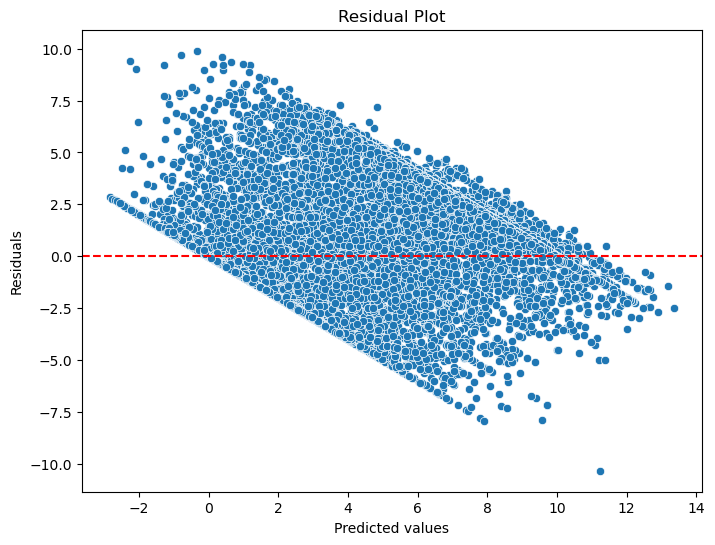

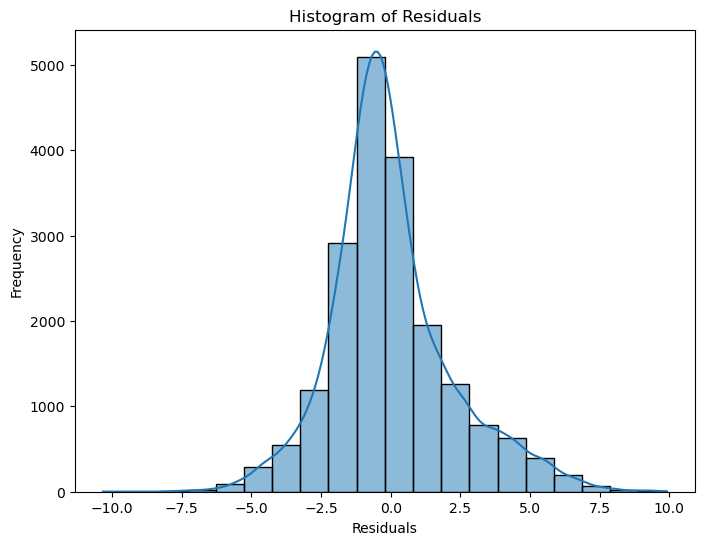

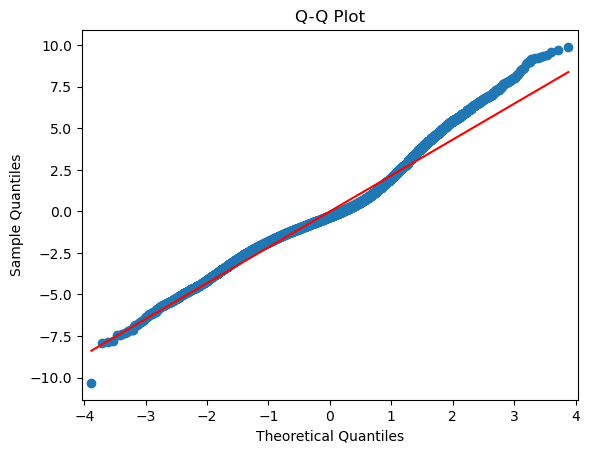

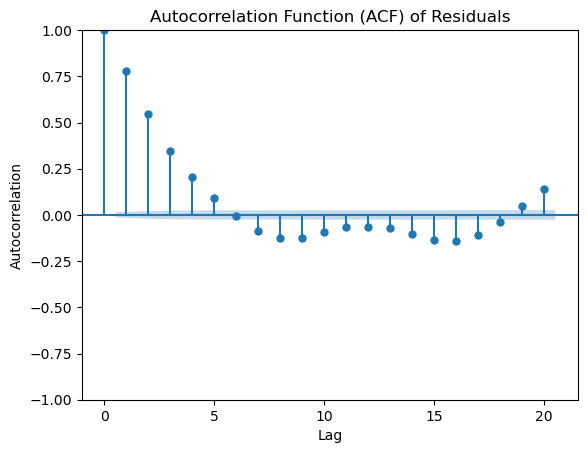

In [9]:
filtered_df = pd.merge(production_df, weather_info_df, on='datetime', how='inner')
filtered_df = filtered_df.dropna()

X = filtered_df.drop(['datetime', 'production'], axis=1)  # Features
y = filtered_df['production']  # Target variable

X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()

# Print the summary of the model
print(model.summary())

# Residuals
residuals = model.resid

# Residual Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(model.predict(), residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.show()

# Histogram of Residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=20, edgecolor='k',kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Q-Q Plot (Quantile-Quantile Plot)
sm.qqplot(residuals, line='r')
plt.title('Q-Q Plot')
plt.show()

# ACF Plot
sm.graphics.tsa.plot_acf(residuals, lags=20)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

As one can easily observe, the graph showing residuals vs fitted values displays a decreasing trend. Residuals are not randomly scattered around 0. 

Histogram of residuals shows a nice pattern with less outliers in the ends. However, it might be caused by the large sample size indicating law of large numbers.

Q-Q plot also shows the signs of holding normality assumption with a similar reasoning as in the histogram.

One can see a significant autocorrelation exists which suggests lag implementation

#### LAG Implementation

After analyzing above graphs, lagged term is added to the model.
shift(72) stands for the scaled production three days before, and each 24 hours increment depicts one day lag. lag(24) and lag(48) cannot be used since prediction for d+1 is made by the past production data up until the end of day d-2.

                            OLS Regression Results                            
Dep. Variable:             production   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     6223.
Date:                Wed, 05 Jun 2024   Prob (F-statistic):               0.00
Time:                        15:18:50   Log-Likelihood:                -38209.
No. Observations:               19315   AIC:                         7.644e+04
Df Residuals:                   19303   BIC:                         7.654e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

c:\Users\saime\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


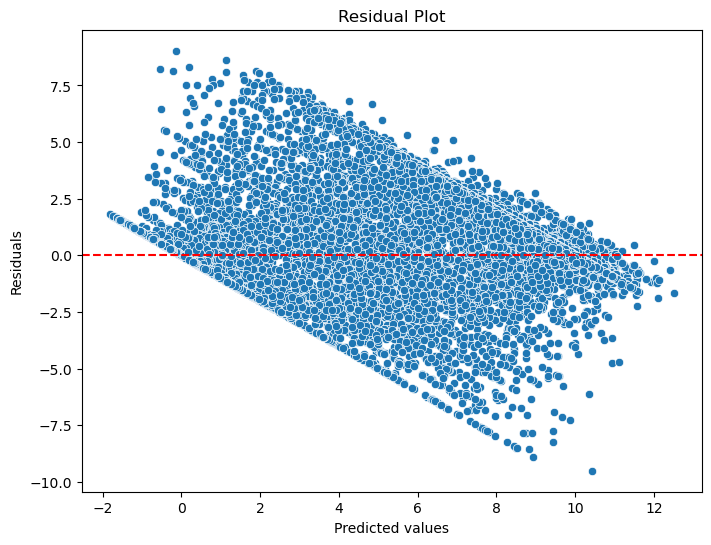

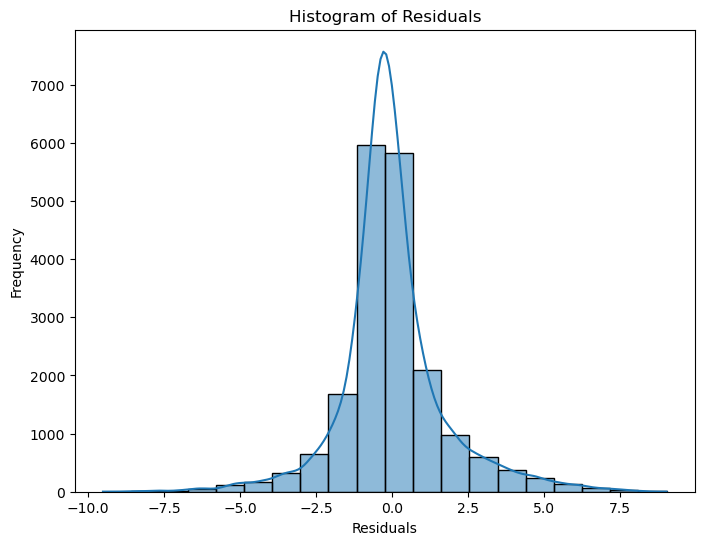

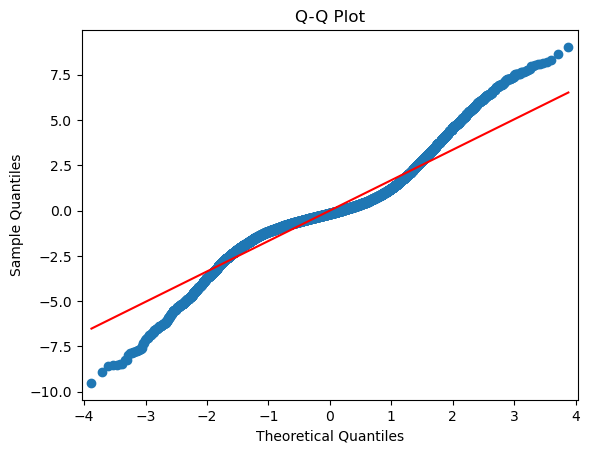

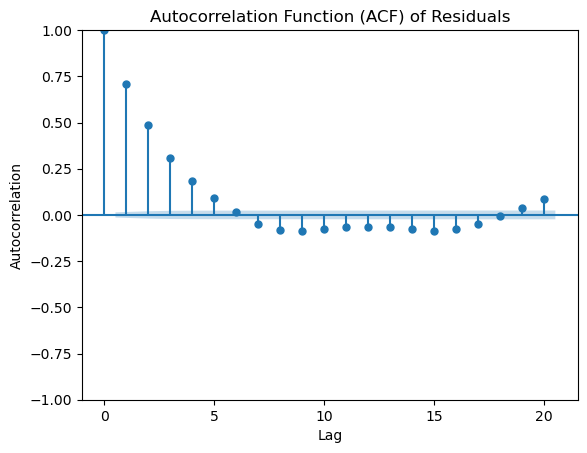

In [10]:
filtered_df1 = pd.merge(production_df, weather_info_df, on='datetime', how='inner')

filtered_df1['lag_3'] = filtered_df1['production'].shift(72)
filtered_df1 = filtered_df1.dropna()

X = filtered_df1.drop(['datetime', 'production'], axis=1)  # Features
y = filtered_df1['production']  # Target variable

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print(model.summary())

# Residuals
residuals = model.resid

# Residual Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(model.predict(), residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.show()

# Histogram of Residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=20, edgecolor='k',kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Q-Q Plot (Quantile-Quantile Plot)
sm.qqplot(residuals, line='r')
plt.title('Q-Q Plot')
plt.show()

# ACF Plot
sm.graphics.tsa.plot_acf(residuals, lags=20)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

Siginificant increase in R^2 is observed from 0.67 to 0.78.

As one can easily observe, the graph showing residuals vs fitted values still displays a decreasing trend. Residuals are not randomly scattered around 0. 

After adding lagged variable, the variability in the ends of normal distribution has increased. However, we can say that it still resembles the Normal distribution. The discussion for large sample size still holds.

Q-Q plot displays deviation from Normal distriibution after adding lagged term. There is still room for improvement.

One can see a significant decrease in autocorrelation in lag 3 in ACF plot, however, we need to add more explanatory variables

#### Hourly Filter

By visually inspecting the production data, it can be seen that production outside of hour 6.00 and 19.00 is usually 0. This is because of the sunlight duration in the day. Therefore data is filtered.

                            OLS Regression Results                            
Dep. Variable:             production   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.479
Method:                 Least Squares   F-statistic:                     892.1
Date:                Wed, 05 Jun 2024   Prob (F-statistic):               0.00
Time:                        15:18:58   Log-Likelihood:                -23544.
No. Observations:                9693   AIC:                         4.711e+04
Df Residuals:                    9682   BIC:                         4.719e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    -

c:\Users\saime\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


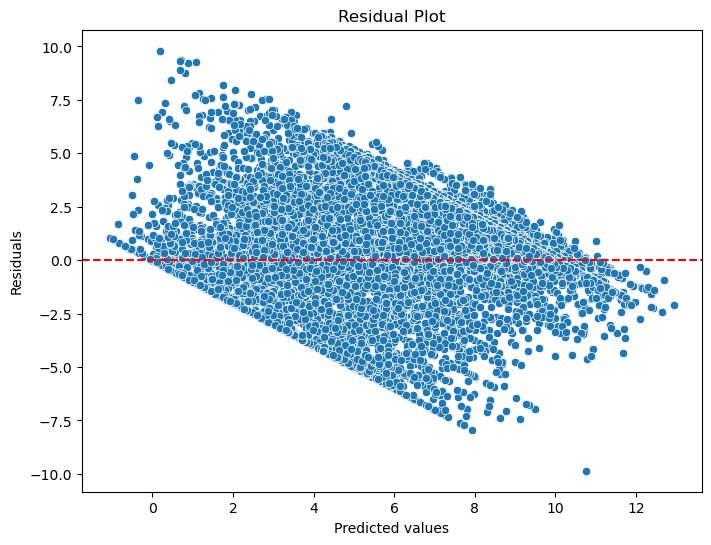

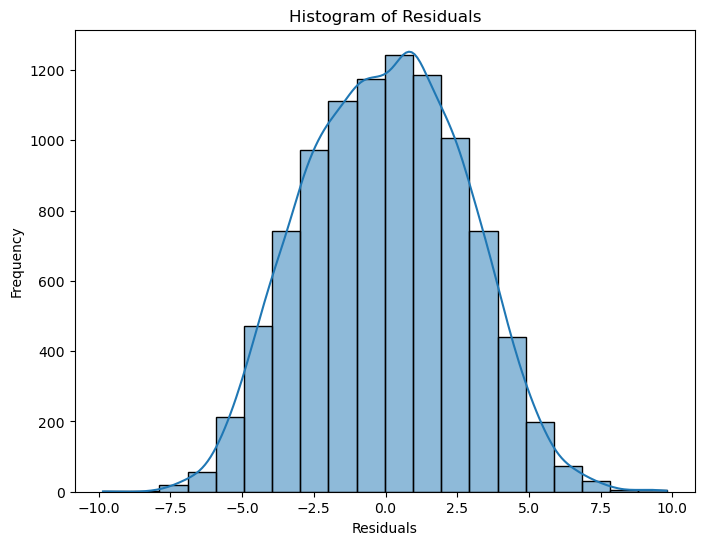

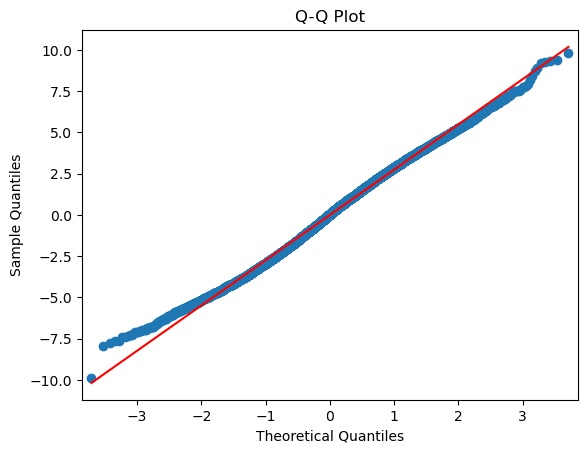

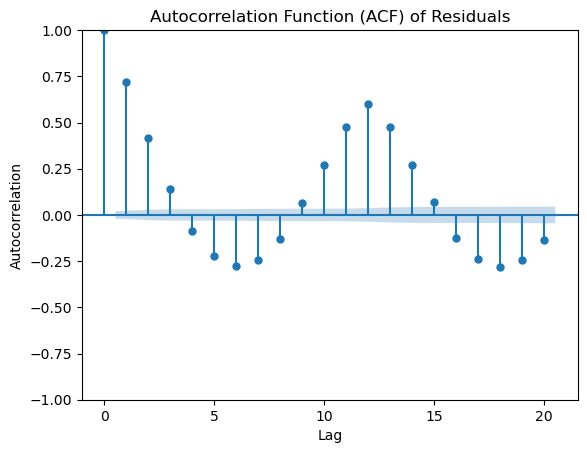

In [11]:
filtered_df3 = pd.merge(production_df, weather_info_df, on='datetime', how='inner')

filtered_df3 = filtered_df3[~((filtered_df3['datetime'].dt.hour >= 19) | (filtered_df3['datetime'].dt.hour <= 6))]
filtered_df3 = filtered_df3.dropna()

X = filtered_df3.drop(['datetime', 'production'], axis=1)  # Features
y = filtered_df3['production']  # Target variable

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print(model.summary())

# Residuals
residuals = model.resid

# Residual Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(model.predict(), residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.show()

# Histogram of Residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=20, edgecolor='k',kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Q-Q Plot (Quantile-Quantile Plot)
sm.qqplot(residuals, line='r')
plt.title('Q-Q Plot')
plt.show()

# ACF Plot
sm.graphics.tsa.plot_acf(residuals, lags=20)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

R^2 is very low in this model, 0.48. This is probably because of the overfitting discussion. 0 values explained the variability very much but it was misleading for our regression

As one can easily observe, the graph showing residuals vs fitted values still displays a decreasing trend. Residuals are not randomly scattered around 0. 

After filtering the data, the variability in the ends of normal distribution has decreased. The normality assumption holds better in this case.

Q-Q plot doesn't deviate from the diagonal compared to the previous regression with only lagged term.


#### Lagged Temperature without Time Filter

Surface temperature affects the production with 1 hour lag because of the accumulation of heat in the surface. Therefore, 1 hour shift is added for the TMP_surface variable.

                            OLS Regression Results                            
Dep. Variable:             production   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     8098.
Date:                Wed, 05 Jun 2024   Prob (F-statistic):               0.00
Time:                        15:19:04   Log-Likelihood:                -35472.
No. Observations:               19314   AIC:                         7.097e+04
Df Residuals:                   19301   BIC:                         7.107e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

c:\Users\saime\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


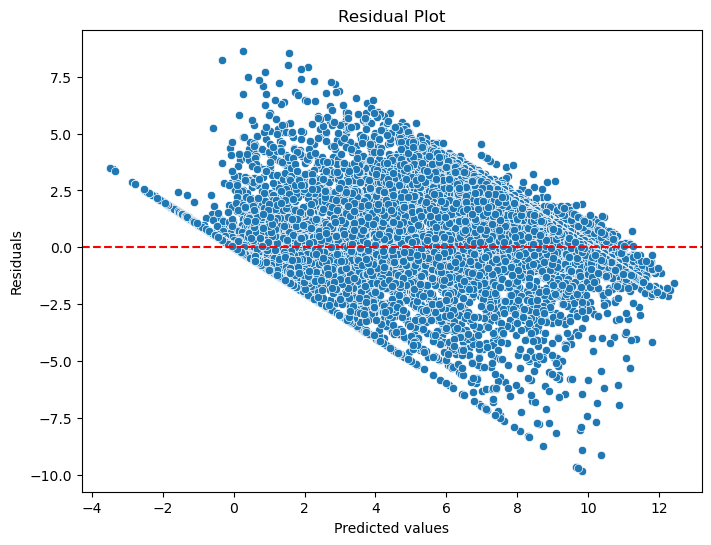

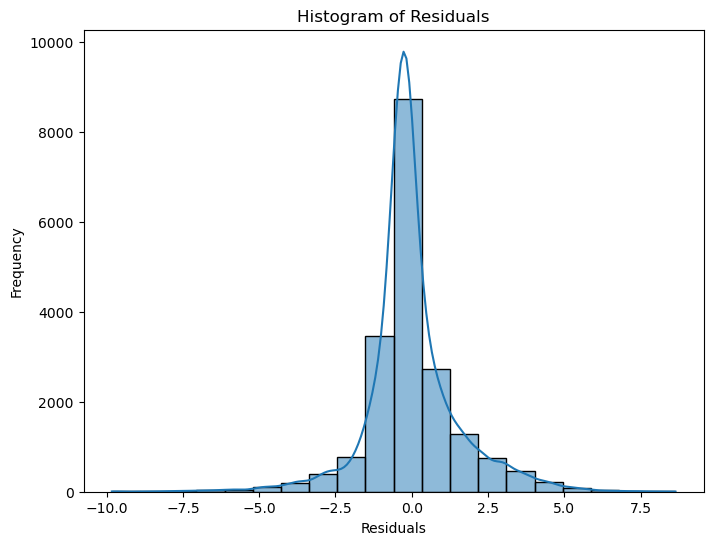

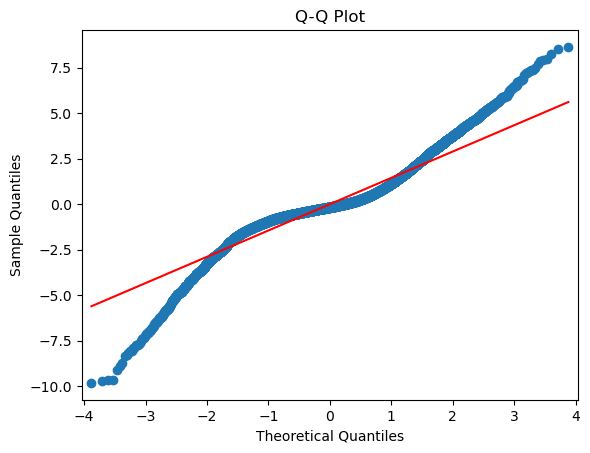

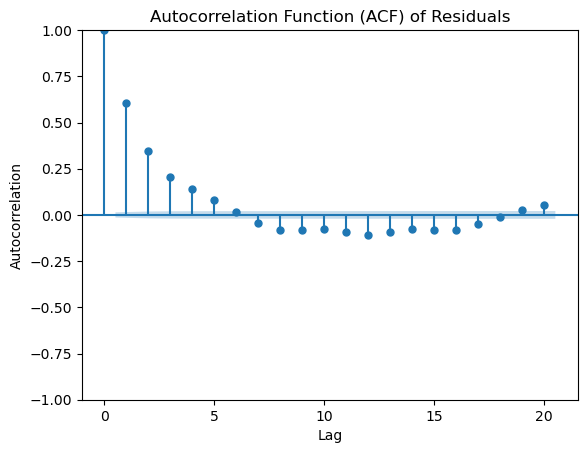

In [12]:
filtered_df5 = pd.merge(production_df, weather_info_df, on='datetime', how='inner')

filtered_df5['lag_3'] = filtered_df5['production'].shift(72)
filtered_df5['TMP_1'] = filtered_df5['TMP_surface'].shift(1)

filtered_df5 = filtered_df5.dropna()

X = filtered_df5.drop(['datetime', 'production'], axis=1)  # Features
y = filtered_df5['production']  # Target variable


X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print(model.summary())

# Residuals
residuals = model.resid

# Residual Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(model.predict(), residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.show()

# Histogram of Residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=20, edgecolor='k',kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Q-Q Plot (Quantile-Quantile Plot)
sm.qqplot(residuals, line='r')
plt.title('Q-Q Plot')
plt.show()

# ACF Plot
sm.graphics.tsa.plot_acf(residuals, lags=20)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

R^2 value is much more better in this model, which is 0.83. Therefore, we can say that the accumulation of heat is important for the production of electricity.

As one can easily observe, the graph showing residuals vs fitted values still displays a decreasing trend. Residuals are not randomly scattered around 0. 

After adding lagged temperature variable, the variability in the ends of normal distribution has increased similar to the lag(3) case. The normality assumption holds worse in this case.

Q-Q plot deviates from the diagonal compared to the previous regression.

#### Time Filter with Temperature Lag and Production Lag

At this point, we will combine our explanatory variables in one regression and observe the affect of them with p values of the regression.

                            OLS Regression Results                            
Dep. Variable:             production   R-squared:                       0.683
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     1589.
Date:                Wed, 05 Jun 2024   Prob (F-statistic):               0.00
Time:                        15:19:11   Log-Likelihood:                -18889.
No. Observations:                8851   AIC:                         3.780e+04
Df Residuals:                    8838   BIC:                         3.790e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

c:\Users\saime\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


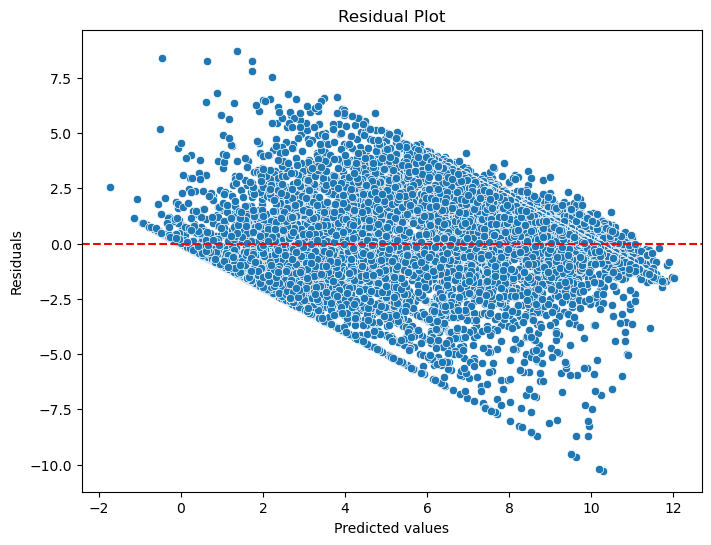

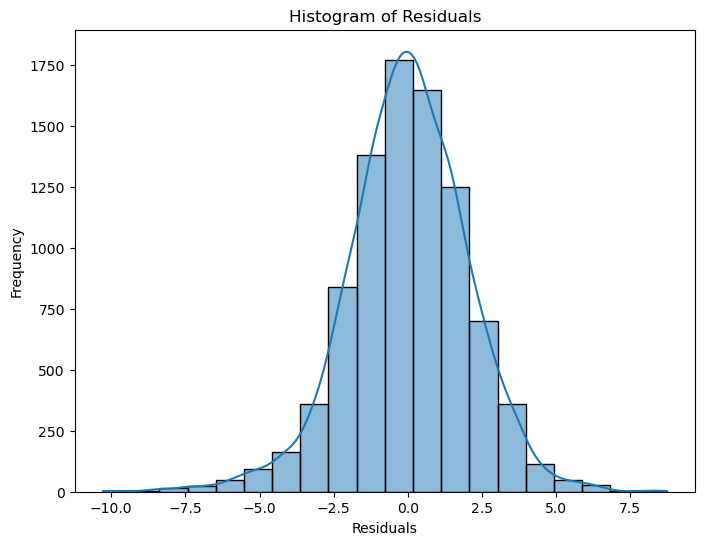

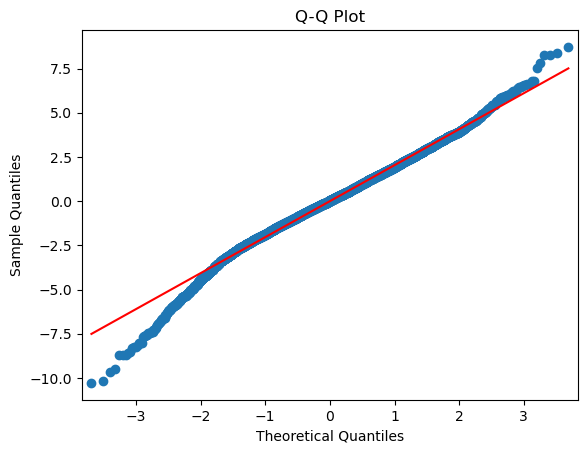

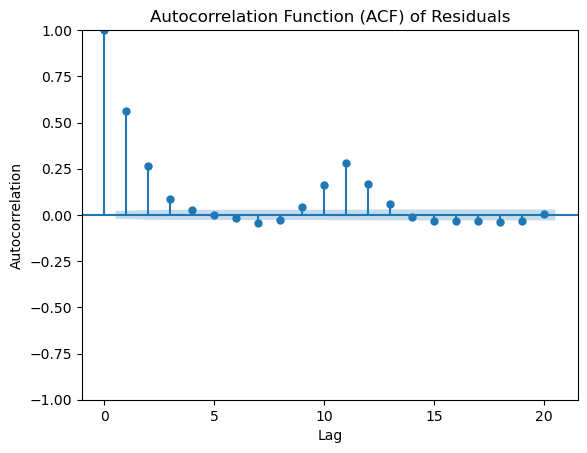

In [13]:
filtered_df6 = pd.merge(production_df, weather_info_df, on='datetime', how='inner')

filtered_df6['lag_3'] = filtered_df6['production'].shift(72)
filtered_df6['TMP_1'] = filtered_df6['TMP_surface'].shift(1)
filtered_df6 = filtered_df6[~((filtered_df6['datetime'].dt.hour >= 18) | (filtered_df6['datetime'].dt.hour <= 6))]

filtered_df6 = filtered_df6.dropna()

X = filtered_df6.drop(['datetime', 'production'], axis=1)  # Features
y = filtered_df6['production']  # Target variable

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print(model.summary())

# Residuals
residuals = model.resid

# Residual Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(model.predict(), residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.show()

# Histogram of Residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=20, edgecolor='k',kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Q-Q Plot (Quantile-Quantile Plot)
sm.qqplot(residuals, line='r')
plt.title('Q-Q Plot')
plt.show()

# ACF Plot
sm.graphics.tsa.plot_acf(residuals, lags=20)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

The p values of the explanatory variables added by us (lag(3), temperature lag) are very low. So they perform well in terms of explaining the relation.

R^2 is high, 0.83 compared to other models because we are explaining the variability in response by our regression better.

As one can easily observe, the graph showing residuals vs fitted values still displays a decreasing trend. Residuals are not randomly scattered around 0. 

After filtering the data and adding lagged variables, the variability in the ends of normal distribution has decreased. The normality assumption holds better in this case.

Q-Q plot doesn't deviate from the diagonal compared to the previous regressions

#### Hourly and Monthly dummy variables

Since the data includes seasonality and there is still trend in the residuals vs fitted plots in previous regressions, seasonal dummy variables are added to the model. Hourly seasonal variable is because of the sunlight effect in different hours of the day. Monthly seasonal variable is because of teh summer and winter effect.

                            OLS Regression Results                            
Dep. Variable:             production   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     1090.
Date:                Wed, 05 Jun 2024   Prob (F-statistic):               0.00
Time:                        15:19:18   Log-Likelihood:                -21062.
No. Observations:               10461   AIC:                         4.220e+04
Df Residuals:                   10425   BIC:                         4.246e+04
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

c:\Users\saime\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


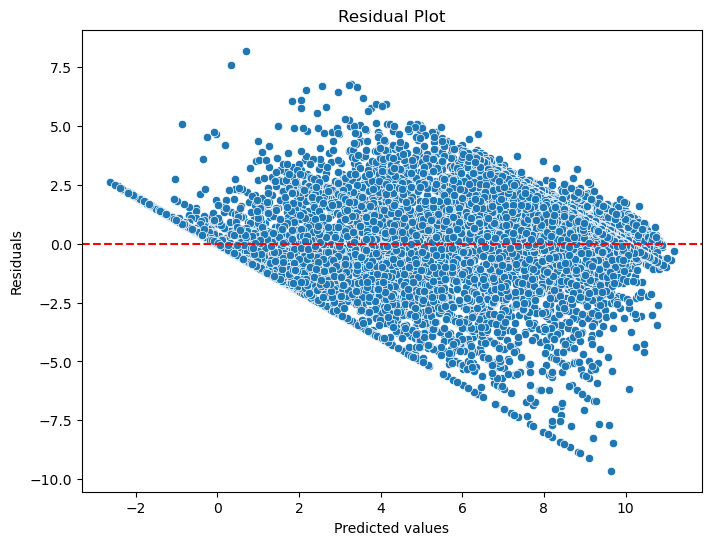

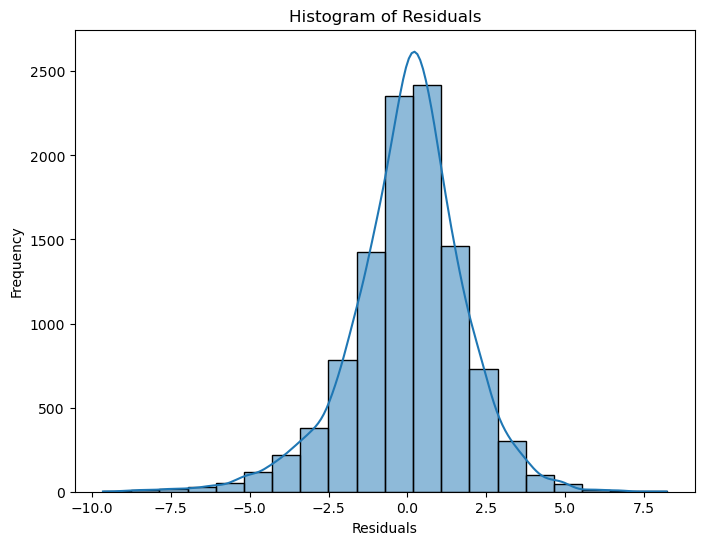

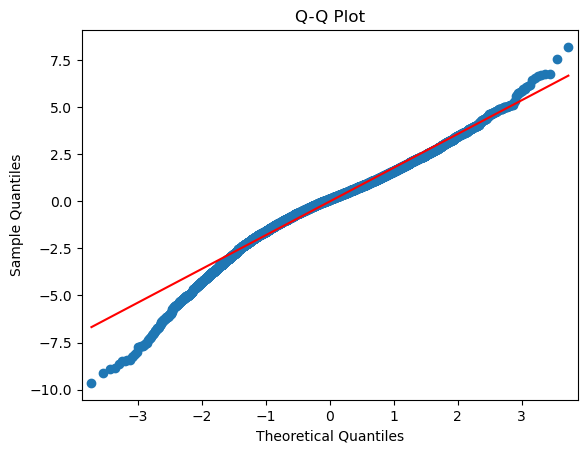

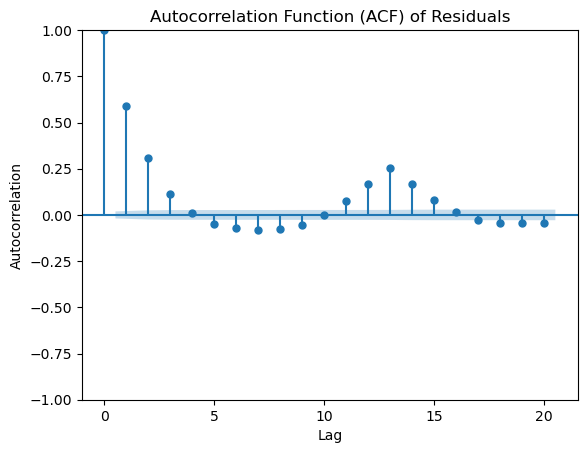

In [14]:
filtered_df7 = pd.merge(production_df, weather_info_df, on='datetime', how='inner')

filtered_df7['lag_3'] = filtered_df7['production'].shift(72)
filtered_df7['TMP_1'] = filtered_df7['TMP_surface'].shift(1)
#filtered_df7['production_diff'] = filtered_df7['production'].diff(24)

filtered_df7['hour'] = filtered_df7['datetime'].dt.hour
filtered_df7['month'] = filtered_df7['datetime'].dt.month

filtered_df7 = filtered_df7[~((filtered_df7['datetime'].dt.hour >= 20) | (filtered_df7['datetime'].dt.hour <= 6))]
filtered_df7['month_name'] = filtered_df7['month'].apply(lambda x: pd.to_datetime('2023-'+str(x)+'-01').strftime('%B'))

month_dummies = pd.get_dummies(filtered_df7['month_name'], prefix='is')


# Join the dummy variables with the original DataFrame
filtered_df7 = pd.concat([filtered_df7, month_dummies], axis=1)

filtered_df7.drop(['month', 'month_name'], axis=1, inplace=True)

hours_to_include = list(range(7, 20))  # This will include 7 to 19

for hour in hours_to_include:
   filtered_df7[f'hour_{hour}'] = (filtered_df7['hour'] == hour).astype(int)
    
filtered_df7.drop('hour', axis=1, inplace=True)
filtered_df7 = filtered_df7.dropna()
    
X = filtered_df7.drop(['datetime', 'production'], axis=1)  # Features
y = filtered_df7['production']  # Target variable

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print(model.summary())

# Residuals
residuals = model.resid

# Residual Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(model.predict(), residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.show()

# Histogram of Residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=20, edgecolor='k',kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Q-Q Plot (Quantile-Quantile Plot)
sm.qqplot(residuals, line='r')
plt.title('Q-Q Plot')
plt.show()

# ACF Plot
sm.graphics.tsa.plot_acf(residuals, lags=20)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

The p values of the explanatory variables added by us (lag(3), temperature lag) are very low. So they perform well in terms of explaining the relation.

The effect of dummy variables is not obvious in residual analysis however, by looking at the p values, we can conclude that they explain the variability in the response.

Also, visual inspection strongly encourages us for seasonal dummy variables.

**4. Base Linear regression Model**

The below model uses all the explanatory variables that are introduced in previous cells. Also, the model is tested for the period from February 1st to May 15th. The training period for the model is extended after each day-ahead forecast


Expanding Retraining Window for Time Series Cross-Validation:

A key aspect of the approach is the implementation of an expanding retraining window for time series cross-validation. This strategy addresses the challenge of non-stationary data, which is common in time series forecasting.

Here's how the expanding retraining window works:

The model is initially trained using data up to a specific point in time (e.g., February 1st).
Predictions are made for a designated future period (e.g., the next day).
After the actual values for the predicted period become available (e.g., after the next day), the model is retrained.
The retraining process incorporates the new data, essentially expanding the training window. This helps the model adapt to any evolving trends or patterns in the data.
Steps 2-4 are repeated for subsequent prediction periods, with the training window continually expanding to include the latest available data.

This approach offers several advantages:

Improved Accuracy: By incorporating the latest data into the training process, the model can potentially adapt to changing patterns and improve its prediction accuracy over time.
Adaptability to Non-Stationarity: The expanding window helps the model handle non-stationarity by continuously updating its understanding of the underlying relationships.

Day-Ahead Prediction with One-Day Lag Training:

Our model focuses on day-ahead prediction, aiming to forecast hourly solar power production for the day following the forecasting day. Notably, the training process utilizes data from the day preceding the forecasting day. This ensures that the model has access to the most recent information about weather conditions and past production levels before making predictions.

In [15]:
def forecast_solar_production(production_df, weather_info_df):
    # Merge production and weather data on datetime
    df = pd.merge(production_df, weather_info_df, on='datetime', how='inner')

    # Initialize the model
    model = LinearRegression()
    
    df['lag_3'] = df['production'].shift(72)
    #df['lag_2'] = df['production'].shift(48)
    df['TMP_1'] = df['TMP_surface'].shift(1)
    
    df = df[~((df['datetime'].dt.hour >= 20) | (df['datetime'].dt.hour <= 5))]
    
    df['hour'] = df['datetime'].dt.hour
    df['month'] = df['datetime'].dt.month

    df['month_name'] = df['month'].apply(lambda x: pd.to_datetime(f'2023-{int(x):02d}-01').strftime('%B') if pd.notna(x) else 'Unknown')

    month_dummies = pd.get_dummies(df['month_name'], prefix='is')

    # Join the dummy variables with the original DataFrame
    df = pd.concat([df, month_dummies], axis=1)

    df.drop(['month', 'month_name'], axis=1, inplace=True)

    hours_to_include = list(range(6, 20))  # This will include 6 to 19

    for hour in hours_to_include:
        df[f'hour_{hour}'] = (df['hour'] == hour).astype(int)
    
    df.drop('hour', axis=1, inplace=True)
    df = df.dropna()

    # Define the start and end dates for prediction
    start_date = pd.to_datetime('2024-02-01')
    end_date = pd.to_datetime('2024-05-15')

    # Create a list to store predictions and WMAPE calculations
    predictions = []
    wmape_values = []

    # Loop through each day in the prediction period
    current_date = start_date
    while current_date <= end_date:
        # Define the training period
        train_end_date = current_date - pd.Timedelta(days=2)
        
        # Create training data
        train_data = df[df['datetime'] <= train_end_date]
        
        # Create test data
        test_start_date = current_date
        test_end_date = current_date + pd.Timedelta(hours=23)
        test_data = df[(df['datetime'] >= test_start_date) & (df['datetime'] <= test_end_date)]
        
        if train_data.empty or test_data.empty:
            current_date += pd.Timedelta(days=1)
            continue

        # Define features and target
        X_train = train_data.drop(columns=['datetime', 'production'])
        y_train = train_data['production']
        X_test = test_data.drop(columns=['datetime', 'production'])
        y_test = test_data['production']

        # Train the model
        model.fit(X_train, y_train)

        # Predict the production for the next 24 hours using linear regression
        y_pred_lr = model.predict(X_test)

        # Calculate residuals
        residuals = y_train - model.predict(X_train)

        # Combine linear regression predictions with ARIMA residual predictions
        y_pred = []
        for date, lr_pred in zip(test_data['datetime'], y_pred_lr):
            if 6 <= date.hour <= 19:
                y_pred.append(lr_pred)
            else:
                y_pred.append(0)

        # Store the predictions with the corresponding datetime
        for date, pred, in zip(test_data['datetime'], y_pred):
            predictions.append({'datetime': date, 'predicted_production': pred})

        # Calculate WMAPE for the current day
        if sum(y_test) != 0:
            wmape = (sum(abs(y_test - y_pred)) / sum(y_test))
        else:
            wmape = float('inf')  

        wmape_values.append({'date': current_date, 'WMAPE': wmape})

        # Move to the next day
        current_date += pd.Timedelta(days=1)
    
    # Convert predictions to DataFrame
    predictions_df = pd.DataFrame(predictions)
    wmape_df = pd.DataFrame(wmape_values)

    # Calculate overall WMAPE for predictions_df
    merged_df = pd.merge(production_df, predictions_df, on='datetime', how='inner')
    total_production = merged_df['production'].sum()
    total_absolute_error = abs(merged_df['production'] - merged_df['predicted_production']).sum()

    if total_production != 0:
        overall_wmape = (total_absolute_error / total_production)
    else:
        overall_wmape = float('inf') 

    date_range = pd.date_range(start=merged_df['datetime'].min().normalize(), 
                   end=merged_df['datetime'].max().normalize() + pd.Timedelta(days=1) - pd.Timedelta(hours=1),
                   freq='H')

    # Create a new dataframe with the complete date range
    full_range_df = pd.DataFrame(date_range, columns=['datetime'])

    # Merge the new full range dataframe with the original dataframe
    # Use an outer join to keep all dates and fill missing values with 0
    arima_son = full_range_df.merge(merged_df, on='datetime', how='outer').fillna(0)

    # Sorting the dataframe to ensure the datetime order is maintained
    son = arima_son.sort_values(by='datetime').reset_index(drop=True)
    
    son['predicted_production'] = son['predicted_production'].clip(lower=0)
    
    son['residual'] = son['production'] - son['predicted_production']

    return son

In [17]:
data = forecast_solar_production(production_df, weather_info_df)
data

,datetime,production,predicted_production,residual
0,2024-02-01 00:00:00,0.0,0.000000,0.000000
1,2024-02-01 01:00:00,0.0,0.000000,0.000000
2,2024-02-01 02:00:00,0.0,0.000000,0.000000
3,2024-02-01 03:00:00,0.0,0.000000,0.000000
4,2024-02-01 04:00:00,0.0,0.000000,0.000000
...,...,...,...,...
1819,2024-04-16 19:00:00,0.0,0.353857,-0.353857
1820,2024-04-16 20:00:00,0.0,0.000000,0.000000
1821,2024-04-16 21:00:00,0.0,0.000000,0.000000
1822,2024-04-16 22:00:00,0.0,0.000000,0.000000


Residual analysis

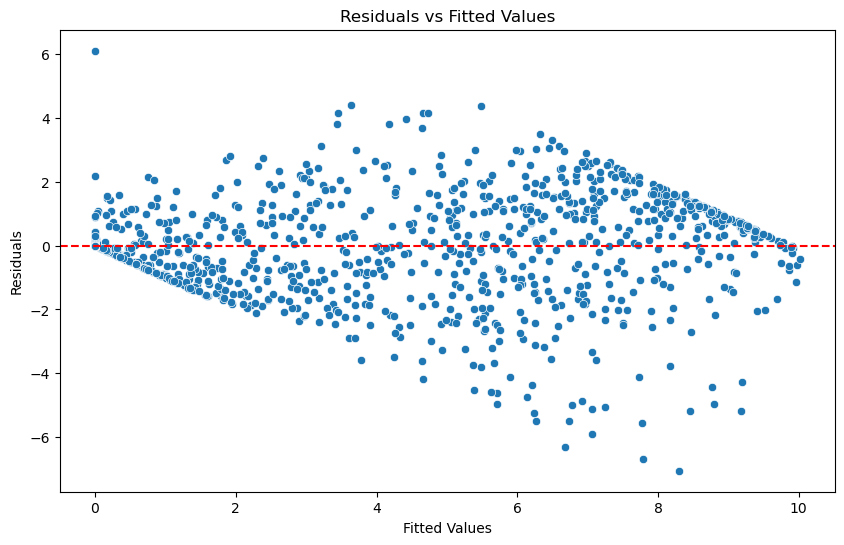

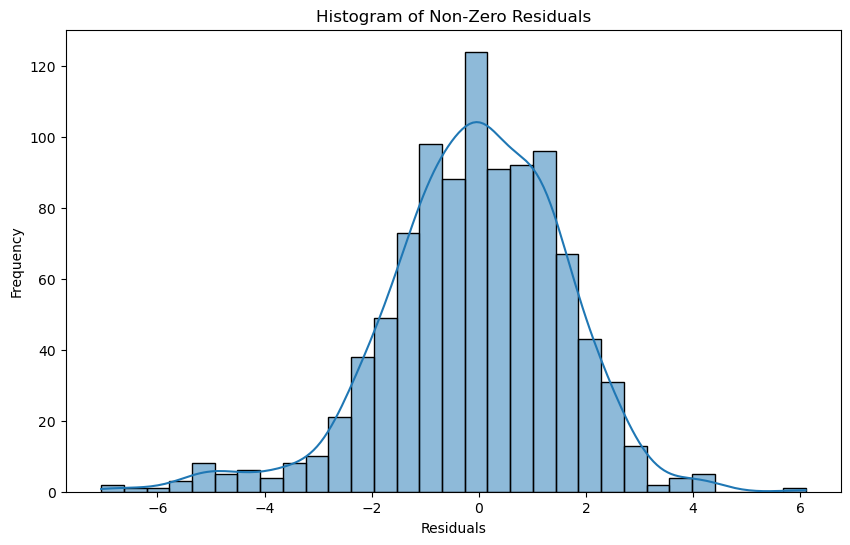

<Figure size 1000x600 with 0 Axes>

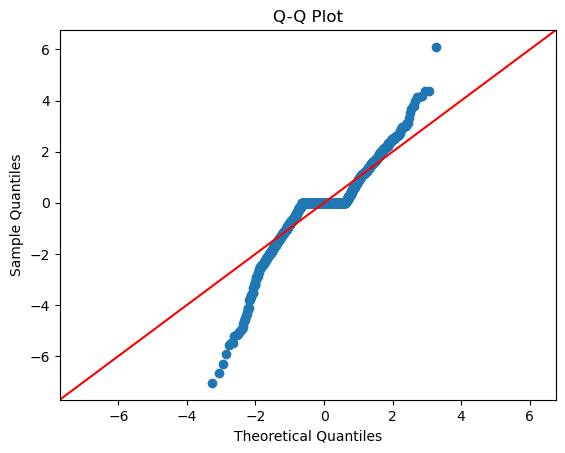

<Figure size 1000x600 with 0 Axes>

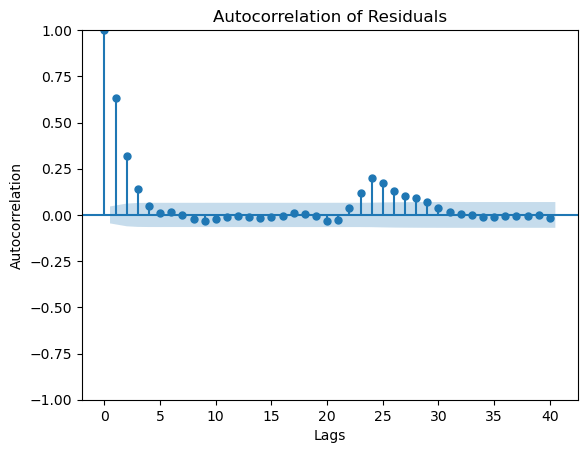

In [18]:
"""
Parameters:
model_data (pd.DataFrame): DataFrame containing 'datetime', 'production', 'predicted_production', and 'residual'
"""
# Residuals vs. Fitted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['predicted_production'], y=data['residual'])
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

#Histogram of residuals
non_zero_residuals = data[data['residual'] != 0]['residual']
plt.figure(figsize=(10, 6))
sns.histplot(non_zero_residuals, kde=True)
plt.title('Histogram of Non-Zero Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Q-Q plot of residuals
plt.figure(figsize=(10, 6))
sm.qqplot(data['residual'], line='45')
plt.title('Q-Q Plot')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()

# Autocorrelation plot of residuals
plt.figure(figsize=(10, 6))
sm.graphics.tsa.plot_acf(data['residual'], lags=40)
plt.title('Autocorrelation of Residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()


The significant change can be seen in residuals vs fiteed values because of the number of data points available. Since our test period includes much less datapoint compared to whole data, it shows slightly random behavior around 0.

#### Creating data for fitting ARIMA model to Residuals

Linear regression is fitted until 31st of January to obtain residuals because these residuals will be used to fit ARIMA model

In [15]:
model_1 = LinearRegression()

start_date = pd.to_datetime('2024-02-01')

implementation_df = pd.merge(production_df, weather_info_df, on='datetime', how='inner')
end_data = implementation_df[implementation_df['datetime'] <= start_date]

end_data['lag_3'] = end_data['production'].shift(72)
end_data['TMP_1'] = end_data['TMP_surface'].shift(1)

end_data = end_data[~((end_data['datetime'].dt.hour >= 20) | (end_data['datetime'].dt.hour <= 5))]

end_data['hour'] = end_data['datetime'].dt.hour
end_data['month'] = end_data['datetime'].dt.month

end_data['month_name'] = end_data['month'].apply(lambda x: pd.to_datetime(f'2023-{int(x):02d}-01').strftime('%B') if pd.notna(x) else 'Unknown')

month_dummies = pd.get_dummies(end_data['month_name'], prefix='is')

# Join the dummy variables with the original DataFrame
end_data = pd.concat([end_data, month_dummies], axis=1)

end_data.drop(['month', 'month_name'], axis=1, inplace=True)

hours_to_include = list(range(6, 20))  # This will include 6 to 19

for hour in hours_to_include:
    end_data[f'hour_{hour}'] = (end_data['hour'] == hour).astype(int)

end_data.drop('hour', axis=1, inplace=True)
end_data = end_data.dropna()


Trial_X = end_data.drop(columns=['datetime', 'production'])
Trial_Y = end_data['production']

before_train = model_1.fit(Trial_X , Trial_Y)

pred_trial = model_1.predict(Trial_X)
residuals = Trial_Y - pred_trial

# Predict using the model
end_data['predicted_production'] = model_1.predict(Trial_X)
end_data['predicted_production'] = end_data['predicted_production'].clip(lower=0)

# Calculate residuals
end_data['residual'] = end_data['production'] - end_data['predicted_production']

# Create the new DataFrame
new_df = end_data[['datetime', 'production', 'predicted_production', 'residual']]
new_df

date_range = pd.date_range(start=new_df['datetime'].min().normalize(), 
                   end=new_df['datetime'].max().normalize() + pd.Timedelta(days=1) - pd.Timedelta(hours=1),
                   freq='H')

# Create a new dataframe with the complete date range
full_range_df = pd.DataFrame(date_range, columns=['datetime'])

# Merge the new full range dataframe with the original dataframe
# Use an outer join to keep all dates and fill missing values with 0
completed_df = full_range_df.merge(new_df, on='datetime', how='outer').fillna(0)

# Sorting the dataframe to ensure the datetime order is maintained
data_until31jan = completed_df.sort_values(by='datetime').reset_index(drop=True)

data_until31jan.tail(24)

/var/folders/7z/1qvhzjdn565f662p1x887mbh0000gn/T/ipykernel_9608/3536456755.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  end_data['lag_3'] = end_data['production'].shift(72)
/var/folders/7z/1qvhzjdn565f662p1x887mbh0000gn/T/ipykernel_9608/3536456755.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  end_data['TMP_1'] = end_data['tmp_surface'].shift(1)


,datetime,production,predicted_production,residual
17424,2024-01-31 00:00:00,0.00,0.000000,0.000000
17425,2024-01-31 01:00:00,0.00,0.000000,0.000000
17426,2024-01-31 02:00:00,0.00,0.000000,0.000000
17427,2024-01-31 03:00:00,0.00,0.000000,0.000000
17428,2024-01-31 04:00:00,0.00,0.000000,0.000000
17429,2024-01-31 05:00:00,0.00,0.000000,0.000000
17430,2024-01-31 06:00:00,0.01,0.000000,0.010000
17431,2024-01-31 07:00:00,0.79,1.210639,-0.420639
17432,2024-01-31 08:00:00,5.60,3.027091,2.572909
17433,2024-01-31 09:00:00,8.86,5.156203,3.703797


**5. Hybrid Model (Linear Regression and ARIMA model on Residuals)**

ARIMA model is trained with the data obtained in previous cell which are the residuals of linear regression until January 31st. By doing so, the autocorrelation and variance of residuals are stabilized.

In [ ]:
whole_data = pd.concat([data_until31jan, data]).reset_index(drop=True)

df = whole_data
results_resarima = pd.DataFrame(columns=['date', 'actual'])


test_start_date = datetime(2024, 2, 1, 0, 0)
test_end_date = datetime(2024, 5, 15, 23, 0)

# Loop over each day in the test date range
current_date = test_start_date

while current_date <= test_end_date:
    # Filter the data up to the current date
    train_data = df[df['datetime'] < current_date - pd.Timedelta(days=1)]

    # Fit the auto_arima model without seasonality
    model = auto_arima(train_data['residual'], seasonal=False, stepwise=True, trace=True, suppress_warnings=True)

    forecast = model.predict(n_periods=24)

    # Collect the actual and predicted values
    actual_date = current_date 
    actual_values = df[(df['datetime'] == actual_date)]

    predicted_values = forecast

    # Append to the results DataFrame
    for actual, trial, predicted, date, in zip(actual_values['production'], actual_values['predicted_production'], predicted_values, actual_values['datetime']):
        results_resarima = results_resarima.append({'date': date, 'actual': actual, 'lr':trial,
                                             'lr + arima': trial + predicted}, ignore_index=True)

    # Move to the next date (advance by 2 days)
    current_date += timedelta(days=1)

# Set date as index for results DataFrame
results_resarima['date'] = pd.to_datetime(results_resarima['date'])
results_resarima.set_index('date', inplace=True)

results_resarima.reset_index(inplace=True)
results_resarima.rename(columns={'date': 'datetime'}, inplace=True)
results_resarima = results_resarima[['datetime', 'actual', 'lr', 'lr + arima']]

results_resarima

The outputs are obtained seperately in a csv file before, since the models take long time to work, we will upload previously obtained results of our models.

In [40]:
file_path = '.\done_df.csv'  

# Read the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)

# Extract only the desired columns
specific_columns_df = df[['datetime','production', 'lr + arima']]
specific_columns_df['residuals_hybrid'] = specific_columns_df['production'] - specific_columns_df['lr + arima']

print(specific_columns_df)

                 datetime  production  lr + arima  residuals_hybrid
0     2024-02-01 00:00:00         0.0    0.000000          0.000000
1     2024-02-01 01:00:00         0.0    0.000000          0.000000
2     2024-02-01 02:00:00         0.0    0.000000          0.000000
3     2024-02-01 03:00:00         0.0    0.000000          0.000000
4     2024-02-01 04:00:00         0.0    0.000000          0.000000
...                   ...         ...         ...               ...
2515  2024-05-15 19:00:00         0.0   -0.066306          0.066306
2516  2024-05-15 20:00:00         0.0    0.000000          0.000000
2517  2024-05-15 21:00:00         0.0    0.000000          0.000000
2518  2024-05-15 22:00:00         0.0    0.000000          0.000000
2519  2024-05-15 23:00:00         0.0    0.000000          0.000000

[2520 rows x 4 columns]


C:\Users\saime\AppData\Local\Temp\ipykernel_25580\4274643577.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  specific_columns_df['residuals_hybrid'] = specific_columns_df['production'] - specific_columns_df['lr + arima']


Residual Analysis for Hybrid Model

c:\Users\saime\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


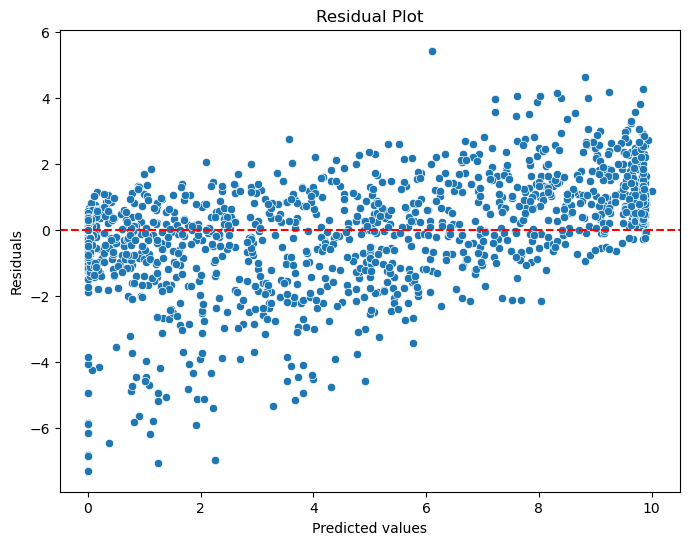

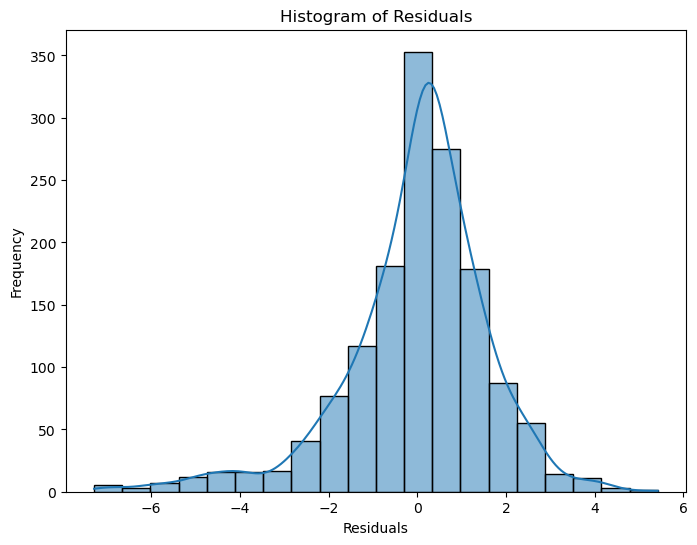

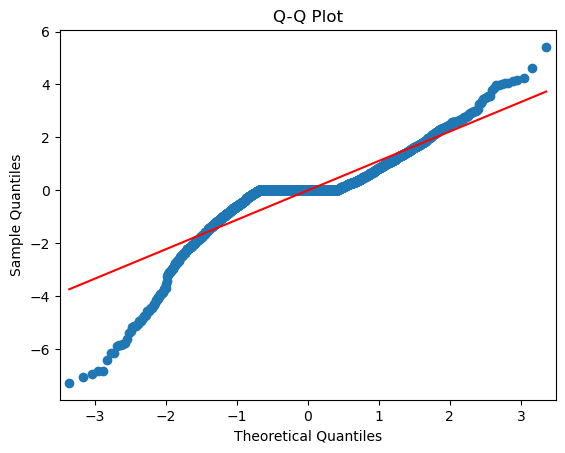

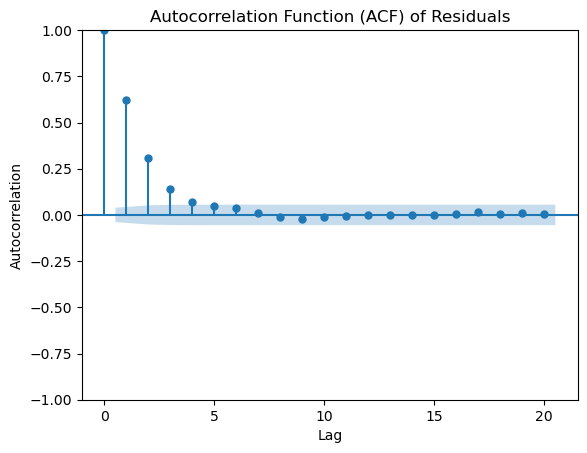

In [41]:
# Residual Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(specific_columns_df["production"], specific_columns_df["residuals_hybrid"])
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.show()

non_zero_residuals = specific_columns_df[specific_columns_df["residuals_hybrid"] != 0]["residuals_hybrid"]
# Histogram of Residuals
plt.figure(figsize=(8, 6))
sns.histplot(non_zero_residuals, bins=20, edgecolor='k',kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Q-Q Plot (Quantile-Quantile Plot)
sm.qqplot(specific_columns_df["residuals_hybrid"], line='r')
plt.title('Q-Q Plot')
plt.show()

# ACF Plot
sm.graphics.tsa.plot_acf(specific_columns_df["residuals_hybrid"], lags=20)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

As one can easily observe, the graph showing residuals vs fitted values almost randomly scattered residuals around 0.the variance is also constant, this is the best residuals vs fitted plot so far.

Histogram suggests the normal distribution but there is still an improvement for variance because it is a little bit skewed in the left tail 

Q-Q plot deviates a little from the diagonal compared to the previous regressions, but still we can say that normalit assumption holds.

Residual analysis comments for hybrid model

**6. ARIMA Model for each hour seperately**

A seperate ARIMA model is fitted for each hour first. Then, day ahead forecast is conducted by applying expanding retraining method. For each day, the train data is taken up until the day before forecast, afterwards, the auto.arima model is fitted for each hour.

In [ ]:
data <- whole_data
results_arima <- tibble(datetime = as.POSIXct(character()), actual = numeric(), arima_hourly = numeric())


test_start_date <- ymd_hms("2024-01-31 00:00:00")
test_end_date <- ymd_hms("2024-02-01 00:00:00") 


for (i in 6:20) {
  df <- data %>% filter(hour(datetime) == i)
  
  test_start_date <- ymd_hms("2024-01-31 00:00:00") + hours(i)
  test_end_date <- ymd_hms("2024-05-15 00:00:00") + hours(i)
  
  # Loop over each day in the test date range
  current_date <- test_start_date
  while (current_date <= test_end_date) {
    # Filter the data up to the current date
    train_data <- df %>% filter(datetime < current_date - days(1))
    
    # Fit the auto.arima model without seasonality
    model <- auto.arima(train_data$production, seasonal = FALSE)
    
    # Forecast the next 2 days
    forecast <- forecast(model, h = 2)
    
    # Collect the actual and predicted values
    actual_values <-  df %>% filter(datetime >= current_date & datetime < current_date + hours(24))
    predicted_values <- forecast[4]$mean[2]  # Forecast for the next day
    
    # Append to the results DataFrame
    if (nrow(actual_values) > 0) {
      results_arima <- results_arima %>% 
        add_row(
          datetime = actual_values$datetime,
          actual = actual_values$production,
          arima_hourly = predicted_values,
        )
    }
    
    # Move to the next date (advance by 2 days)
    current_date <- current_date + days(1)
  }
}
results_arima <- results_arima %>% arrange(datetime)
results_arima

In [43]:
specific_columns_df = df[['datetime','production', 'arima_hourly']]
specific_columns_df['residuals_arima_hourly'] = specific_columns_df['production'] - specific_columns_df['arima_hourly']

print(specific_columns_df)

                 datetime  production  arima_hourly  residuals_arima_hourly
0     2024-02-01 00:00:00         0.0       0.00000                 0.00000
1     2024-02-01 01:00:00         0.0       0.00000                 0.00000
2     2024-02-01 02:00:00         0.0       0.00000                 0.00000
3     2024-02-01 03:00:00         0.0       0.00000                 0.00000
4     2024-02-01 04:00:00         0.0       0.00000                 0.00000
...                   ...         ...           ...                     ...
2515  2024-05-15 19:00:00         0.0       0.00006                -0.00006
2516  2024-05-15 20:00:00         0.0       0.00000                 0.00000
2517  2024-05-15 21:00:00         0.0       0.00000                 0.00000
2518  2024-05-15 22:00:00         0.0       0.00000                 0.00000
2519  2024-05-15 23:00:00         0.0       0.00000                 0.00000

[2520 rows x 4 columns]


C:\Users\saime\AppData\Local\Temp\ipykernel_25580\1630865240.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  specific_columns_df['residuals_arima_hourly'] = specific_columns_df['production'] - specific_columns_df['arima_hourly']


Resşdual Analysis of Hourly ARIMA Model

c:\Users\saime\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


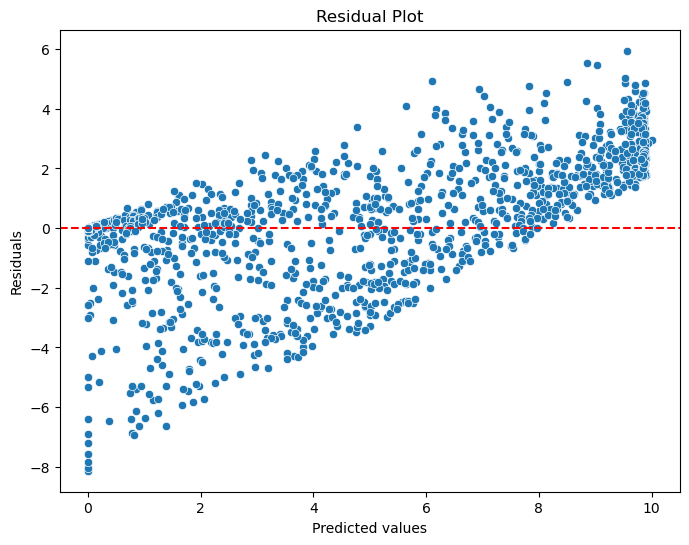

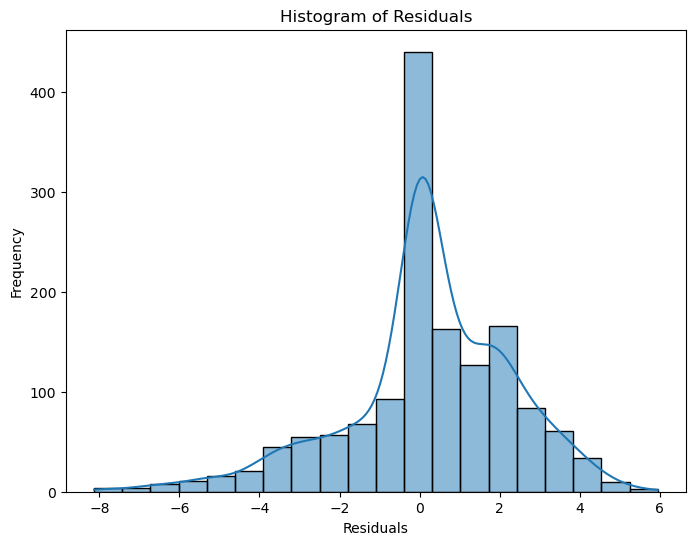

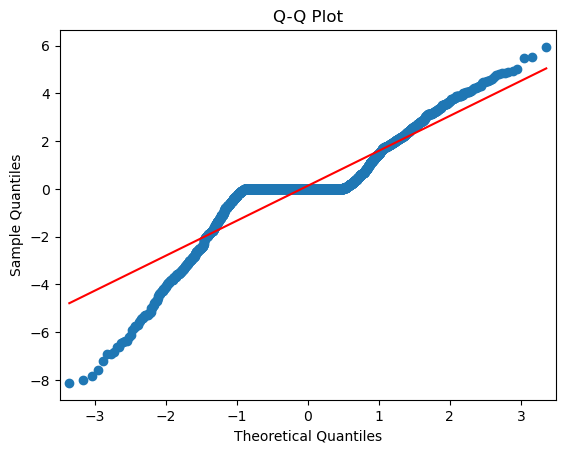

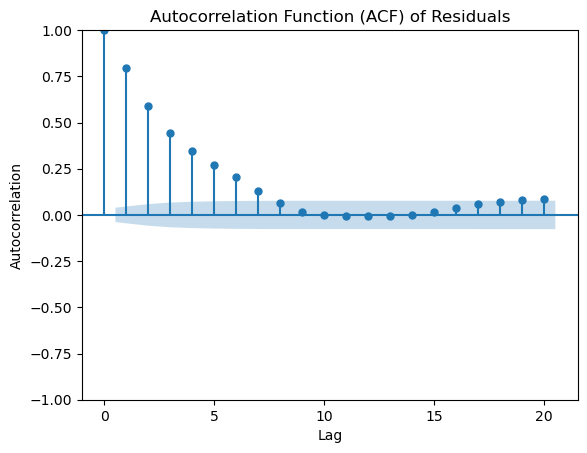

In [44]:
# Residual Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(specific_columns_df["production"], specific_columns_df["residuals_arima_hourly"])
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.show()

non_zero_residuals = specific_columns_df[specific_columns_df["residuals_arima_hourly"] != 0]["residuals_arima_hourly"]
# Histogram of Residuals
plt.figure(figsize=(8, 6))
sns.histplot(non_zero_residuals, bins=20, edgecolor='k',kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Q-Q Plot (Quantile-Quantile Plot)
sm.qqplot(specific_columns_df["residuals_arima_hourly"], line='r')
plt.title('Q-Q Plot')
plt.show()

# ACF Plot
sm.graphics.tsa.plot_acf(specific_columns_df["residuals_arima_hourly"], lags=20)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

Compared to the hybrid model, residual vs fitted graph shows a trend in the residuals, for further improvement, MA smoothing may be applied for the trend variable.

The histogram plot is plotted on non zero residuals, However, again it deviates form normality compared to linear regression models.

We would expect ARIMA model to perform better in ACF function since it integrates AR model and MA model and also differencing. However, it performs worse than the linear models.

**7. Seasonal ARIMA Model**

Seasonal ARIMA model is fitted on daily data. The hourly fitting concept is not applied for Seasonal ARIMA model. The retraining period is expanded again for each day-ahead forecast starting from February 1st tto May 15th. 

In [ ]:
data_sarima = pd.merge(production_df, weather_info_df, on='datetime', how='inner')
results_sarima = pd.DataFrame(columns=['date', 'actual', 'predicted'])

df = data_sarima

test_start_date = datetime(2023, 2, 1, 0, 0)
test_end_date = datetime(2023, 2, 1, 23, 0)

# Loop over each day in the test date range
current_date = test_start_date

while current_date <= test_end_date:
    # Filter the data up to the current date
    train_data = df[df['datetime'] < current_date - pd.Timedelta(days=1)]

    # Fit the auto_arima model without seasonality
    model = auto_arima(train_data['production'], 
                   seasonal=True, 
                   m=24,  # 24-hour seasonality
                   stepwise=True, 
                   suppress_warnings=True,
                      trace= True)

    # Forecast the next 2 days
    forecast = model.predict(n_periods=24)

    # Collect the actual and predicted values
    actual_date = current_date 
    actual_values = df[(df['datetime'] == actual_date)]

    predicted_values = forecast

    # Append to the results DataFrame
    for actual, predicted, date in zip(actual_values['production'], predicted_values, actual_values['datetime']):
        results = results.append({'date': date, 'actual': actual, 'predicted': predicted}, ignore_index=True)

    # Move to the next date (advance by 2 days)
    current_date += timedelta(days=1)

# Set date as index for results DataFrame
results_sarima['date'] = pd.to_datetime(results['date'])
results_sarima.set_index('date', inplace=True)

Since SARIMA model takes longer values to run in Python, we have implemented the code in R as well and take the outputs from R. Below, you can also see the implementation in R.

In [ ]:
# Define the test date range
test_start_date <- as.POSIXct("2024-02-01 00:00:00")
test_end_date <- as.POSIXct("2024-05-15 23:00:00")

# Initialize an empty dataframe to store results
results <- data.frame(date = as.POSIXct(character()), actual = numeric(), predicted = numeric(), stringsAsFactors=FALSE)

# Loop over each day in the test date range
current_date <- test_start_date

while (current_date <= test_end_date) {
  # Filter the data up to the current date
  train_data <- df %>% filter(datetime < current_date - days(1))
  
  production_ts <- ts(train_data$production, frequency=24)
  
  # Fit the auto.arima model with seasonality
  model <- auto.arima(production_ts, 
                      seasonal = T,
                      D = 1,
                      stepwise = F, 
                      trace = T)

  # Forecast the next 24 hours
  forecasted_values <- forecast(model, h = 24)
  
  # Collect the actual and predicted values
  actual_values <- df %>% filter(datetime >= current_date & datetime < current_date + hours(24))
  predicted_values <- forecasted_values$mean
  
  # Append to the results dataframe
  for (i in seq_along(actual_values$production)) {
    results <- rbind(results, data.frame(date = actual_values$datetime[i], 
                                         actual = actual_values$production[i], 
                                         predicted = predicted_values[i]))
  
  }
  
  current_date
  # Move to the next date (advance by 1 day)
  current_date <- current_date + days(1)
  
}

# Set date as index for results dataframe
results_sarima <- results %>% mutate(date = as.POSIXct(date)) %>% arrange(date)
row.names(results_sarima) <- results_sarima$date

# Display the results
results_sarima
```

In [45]:
specific_columns_df = df[['datetime','production', 'sarima']]
specific_columns_df['residuals_sarima'] = specific_columns_df['production'] - specific_columns_df['sarima']

print(specific_columns_df)

                 datetime  production        sarima  residuals_sarima
0     2024-02-01 00:00:00         0.0  0.000000e+00      0.000000e+00
1     2024-02-01 01:00:00         0.0  0.000000e+00      0.000000e+00
2     2024-02-01 02:00:00         0.0  0.000000e+00      0.000000e+00
3     2024-02-01 03:00:00         0.0  0.000000e+00      0.000000e+00
4     2024-02-01 04:00:00         0.0  0.000000e+00      0.000000e+00
...                   ...         ...           ...               ...
2515  2024-05-15 19:00:00         0.0  3.003259e-07     -3.003259e-07
2516  2024-05-15 20:00:00         0.0  4.772338e-06     -4.772338e-06
2517  2024-05-15 21:00:00         0.0  0.000000e+00      0.000000e+00
2518  2024-05-15 22:00:00         0.0  0.000000e+00      0.000000e+00
2519  2024-05-15 23:00:00         0.0  0.000000e+00      0.000000e+00

[2520 rows x 4 columns]


C:\Users\saime\AppData\Local\Temp\ipykernel_25580\959607001.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  specific_columns_df['residuals_sarima'] = specific_columns_df['production'] - specific_columns_df['sarima']


c:\Users\saime\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


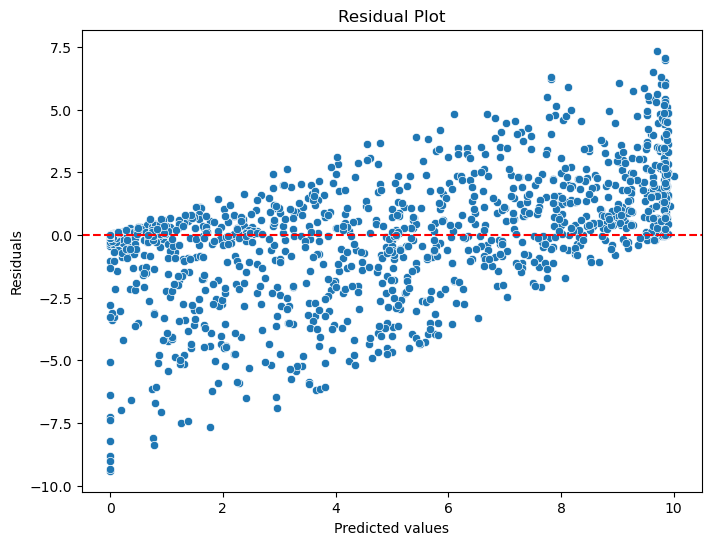

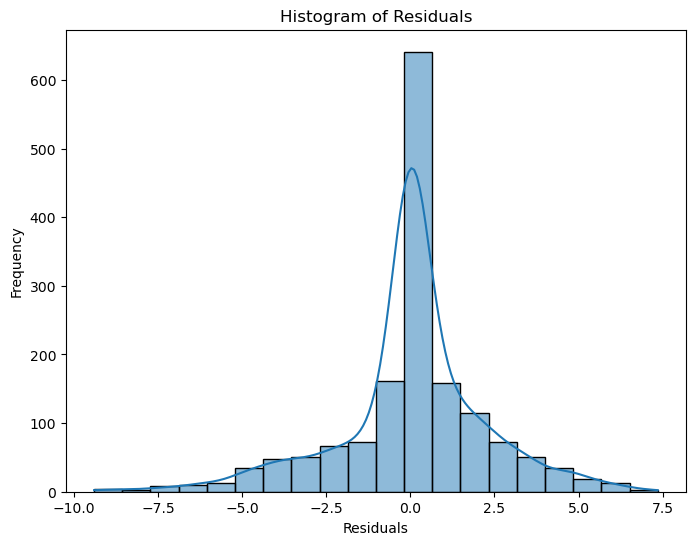

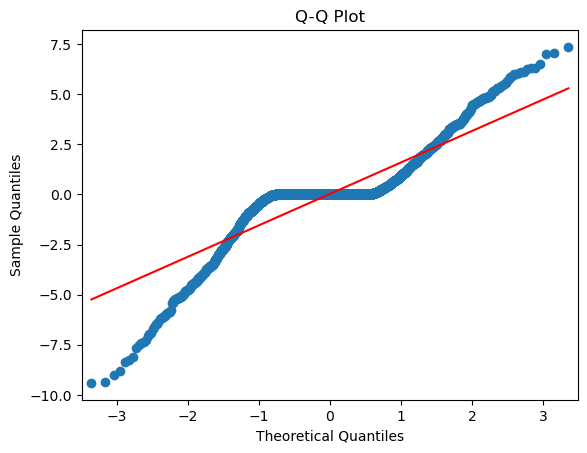

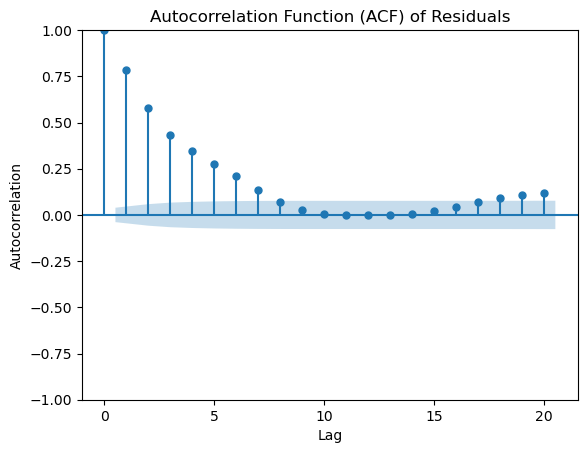

In [46]:
# Residual Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(specific_columns_df["production"], specific_columns_df["residuals_sarima"])
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.show()

non_zero_residuals = specific_columns_df[specific_columns_df["residuals_sarima"] != 0]["residuals_sarima"]
# Histogram of Residuals
plt.figure(figsize=(8, 6))
sns.histplot(non_zero_residuals, bins=20, edgecolor='k',kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


# Q-Q Plot (Quantile-Quantile Plot)
sm.qqplot(specific_columns_df["residuals_sarima"], line='r')
plt.title('Q-Q Plot')
plt.show()

# ACF Plot
sm.graphics.tsa.plot_acf(specific_columns_df["residuals_sarima"], lags=20)
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

Similar to the ARIMA model, residual vs fitted graph shows a trend in the residuals, for further improvement, MA smoothing may be applied for the trend variable.

The histogram plot is plotted on non zero residuals like in the ARIMA model, However, again it deviates form normality compared to linear regression models.

We would expect ARIMA model to perform better in ACF function since it integrates AR model and MA model and also differencing. However, it performs worse than the linear models.

**8. Model Comparisons**

The main comparison metric is weighted mean absolute percentage error (WMAPE) and 4 different models are compared.

    1. Linear Regression Model
    2. Hybrid Model (Linear Regression and ARIMA model on Residuals)
    3. ARIMA Model
    4. Seasonal ARIMA Model

For each hour in the testing period (from February 1st to May 15th) WMAPE values are compared.
Below, you can see teh table of results.


In [29]:
final = pd.read_csv('./done_df.csv')
final['datetime'] = pd.to_datetime(final['datetime'])


# Calculate WMAPE
# Calculate WMAPE
def calculate_wmape(actual, predicted):
    denominator = sum(abs(actual))
    if denominator == 0:
        return np.nan
    return sum(abs(actual - predicted)) / denominator

# Daily WMAPE
final['date'] = final['datetime'].dt.date
daily_wmape = final.groupby('date').apply(lambda x: pd.Series({
    'wmape_arima': calculate_wmape(x['production'], x['arima_hourly']),
    'wmape_sarima': calculate_wmape(x['production'], x['sarima']),
    'wmape_lr': calculate_wmape(x['production'], x['lr']),
    'wmape_lr_arima': calculate_wmape(x['production'], x['lr + arima'])
})).reset_index()

# Monthly WMAPE
final['month'] = final['datetime'].dt.to_period('M')
monthly_wmape = final.groupby('month').apply(lambda x: pd.Series({
    'wmape_arima': calculate_wmape(x['production'], x['arima_hourly']),
    'wmape_sarima': calculate_wmape(x['production'], x['sarima']),
    'wmape_lr': calculate_wmape(x['production'], x['lr']),
    'wmape_lr_arima': calculate_wmape(x['production'], x['lr + arima'])
})).reset_index()

# Overall WMAPE
overall_wmape = pd.DataFrame({
    'wmape_arima': [calculate_wmape(final['production'], final['arima_hourly'])],
    'wmape_sarima': [calculate_wmape(final['production'], final['sarima'])],
    'wmape_lr': [calculate_wmape(final['production'], final['lr'])],
    'wmape_lr_arima': [calculate_wmape(final['production'], final['lr + arima'])]
})

def pretty_print(df, title):
    table = PrettyTable()
    table.field_names = df.columns.tolist()
    for row in df.itertuples(index=False):
        formatted_row = [f"{x:.5f}" if isinstance(x, (float, int)) else x for x in row]
        table.add_row(formatted_row)
    table.title = title
    print(table)


In [30]:
pretty_print(daily_wmape, "Daily WMAPE")
pretty_print(monthly_wmape, "Monthly WMAPE")
pretty_print(overall_wmape, "Overall WMAPE")

+---------------------------------------------------------------------+
|                             Daily WMAPE                             |
+------------+-------------+--------------+----------+----------------+
|    date    | wmape_arima | wmape_sarima | wmape_lr | wmape_lr_arima |
+------------+-------------+--------------+----------+----------------+
| 2024-02-01 |   0.43082   |   0.45044    | 0.45676  |    0.46702     |
| 2024-02-02 |   0.47016   |   0.36842    | 0.26187  |    0.27427     |
| 2024-02-03 |   0.25100   |   0.17268    | 0.20330  |    0.19620     |
| 2024-02-04 |   0.24906   |   0.18569    | 0.31562  |    0.24301     |
| 2024-02-05 |   0.54327   |   0.99542    | 0.46038  |    0.50504     |
| 2024-02-06 |   0.39416   |   0.19683    | 0.36089  |    0.38396     |
| 2024-02-07 |   0.46654   |   0.40100    | 0.23418  |    0.22367     |
| 2024-02-08 |   0.16148   |   0.17105    | 0.20476  |    0.15571     |
| 2024-02-09 |   0.25340   |   0.31079    | 0.40682  |    0.3006

As seen above in the Weighted Mean Absolute Percentage Error Table for 4 models, the lowest WMAPE belongs to the hybrid model which is composed of linear regression and arima model on residuals. Therefore, **hybrid model is chosen to predict production.**

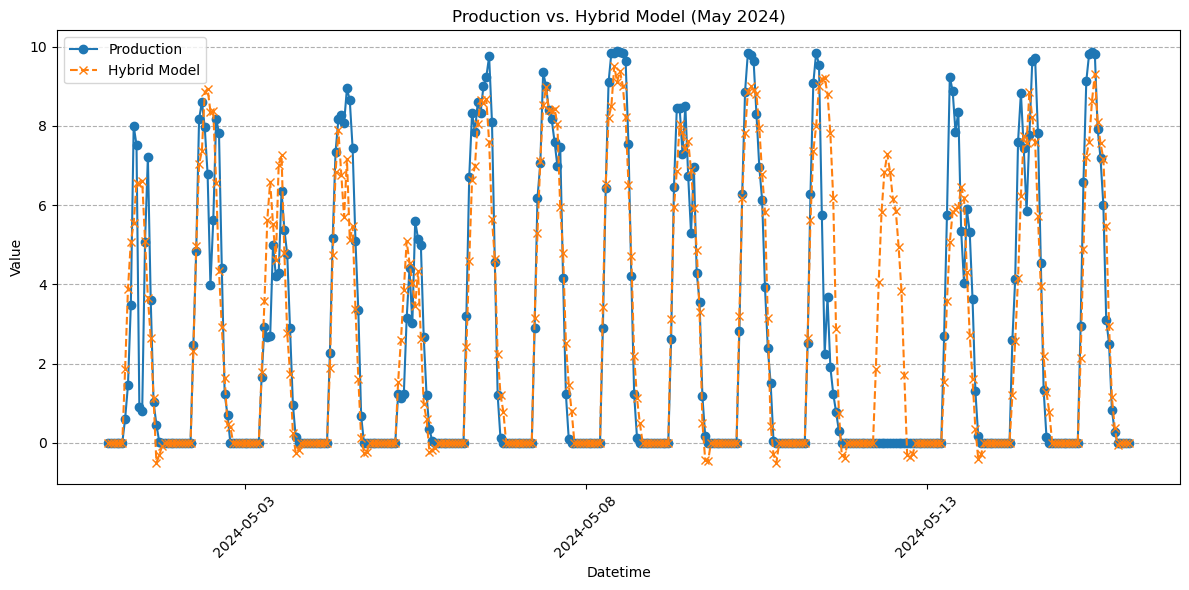

In [35]:
import matplotlib.dates as mdates

# Read the CSV file
file_path = 'done_df.csv'  
df = pd.read_csv(file_path)

df['datetime'] = pd.to_datetime(df['datetime'])  

# Filter data between May 1st and 30th, 2024
final_df = df[
    (df['datetime'] >= '2024-05-01') & (df['datetime'] <= '2024-05-20')
]

# Plotting
plt.figure(figsize=(12, 6))  # Adjust figure size as needed

# Plot 'production' and 'lr + arima'
plt.plot(final_df['datetime'], final_df['production'], marker='o', linestyle='-', label='Production')
plt.plot(final_df['datetime'], final_df['lr + arima'], marker='x', linestyle='--', label='Hybrid Model')

# Formatting
plt.xlabel('Datetime')
plt.ylabel('Value')
plt.title('Production vs. Hybrid Model (May 2024)')
plt.legend()

# Customize x-axis date formatting
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))  # Show every 5 days
plt.xticks(rotation=45) 

plt.tight_layout() 
plt.grid(axis='y', linestyle='--')
plt.show()

### Suggestion for Further Improvement

We have seen that combination of linear regression models and time series methods like ARIMA on residuals perform the best. One can apply auto.arima on residuals for each hour like we did in the hourly ARIMA model and combine the results with the linear regression to get better fitted ARIMA parameters.

Also for the linear regression part, more lagged variables could be added but we need to be careful about over-fitting.

Also, instead of adding hourly and monthly dummy variables, continuous seasonality variables like Fourier series could be fitted.